In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
from scipy.signal import periodogram 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.graphics.tsaplots import plot_acf 

from statsmodels.tsa.deterministic import DeterministicProcess 
from statsmodels.tsa.deterministic import CalendarFourier 


In [3]:
from sklearn.linear_model import ElasticNet 
from sklearn.ensemble import RandomForestRegressor  

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

In [5]:
df = pd.read_csv(r'C:\Users\C J HARINI\Downloads\Gold Price.csv', index_col = 'Date', parse_dates = True, infer_datetime_format = True)
# basic EDA
print("Basic information".center(100, '-'))
df.info()
print("NULL/Duplicate entries".center(100, '-'))
print(f"Number of duplicate entries: {df.duplicated().sum()}")
print(f"Number of null entries: \n{df.isna().sum()}")

-----------------------------------------Basic information------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2227 entries, 2014-01-01 to 2022-08-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2227 non-null   int64  
 1   Open    2227 non-null   int64  
 2   High    2227 non-null   int64  
 3   Low     2227 non-null   int64  
 4   Volume  2227 non-null   int64  
 5   Chg%    2227 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 121.8 KB
---------------------------------------NULL/Duplicate entries---------------------------------------
Number of duplicate entries: 0
Number of null entries: 
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64


In [7]:
def date_split(dataset: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    return pd.DataFrame(dataset.loc[start:end])

In [8]:
train_start = pd.Timestamp(year = 2021, month = 6, day = 17)
train_end = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_start = pd.Timestamp(year = 2021, month = 11, day = 2)
validate_end = pd.Timestamp(year = 2021, month = 12, day = 9)
test_start = pd.Timestamp(year = 2021, month = 12, day = 10)
test_end = pd.Timestamp(year = 2021, month = 12, day = 29)


In [9]:
train_df = date_split(df, train_start, train_end)
validate_df = date_split(df, validate_start, validate_end)
test_df = date_split(df, test_start, test_end)

print(f"""\
Size of train data:\t {train_df.shape[0]}
Size of validate data:\t {validate_df.shape[0]}
Size of test data:\t {test_df.shape[0]}
""")

Size of train data:	 98
Size of validate data:	 28
Size of test data:	 14



In [14]:
def trend_plot(dataset: pd.DataFrame, target: str, window_size : int, center: bool = True) -> None:
    average = dataset.rolling(window_size, center = center, min_periods = window_size // 2).mean()[target].to_frame()
    average = average.rename(columns = {target: f'Average({window_size})'})
    figure, ax = plt.subplots(1, 1, figsize = (16, 8))
    sns.lineplot(data = dataset, x = 'Date', y = target, ax = ax, label = target)
    sns.lineplot(data = average, x = 'Date', y = f'Average({window_size})', ax = ax, label = f'Average({window_size})')
    plt.show()


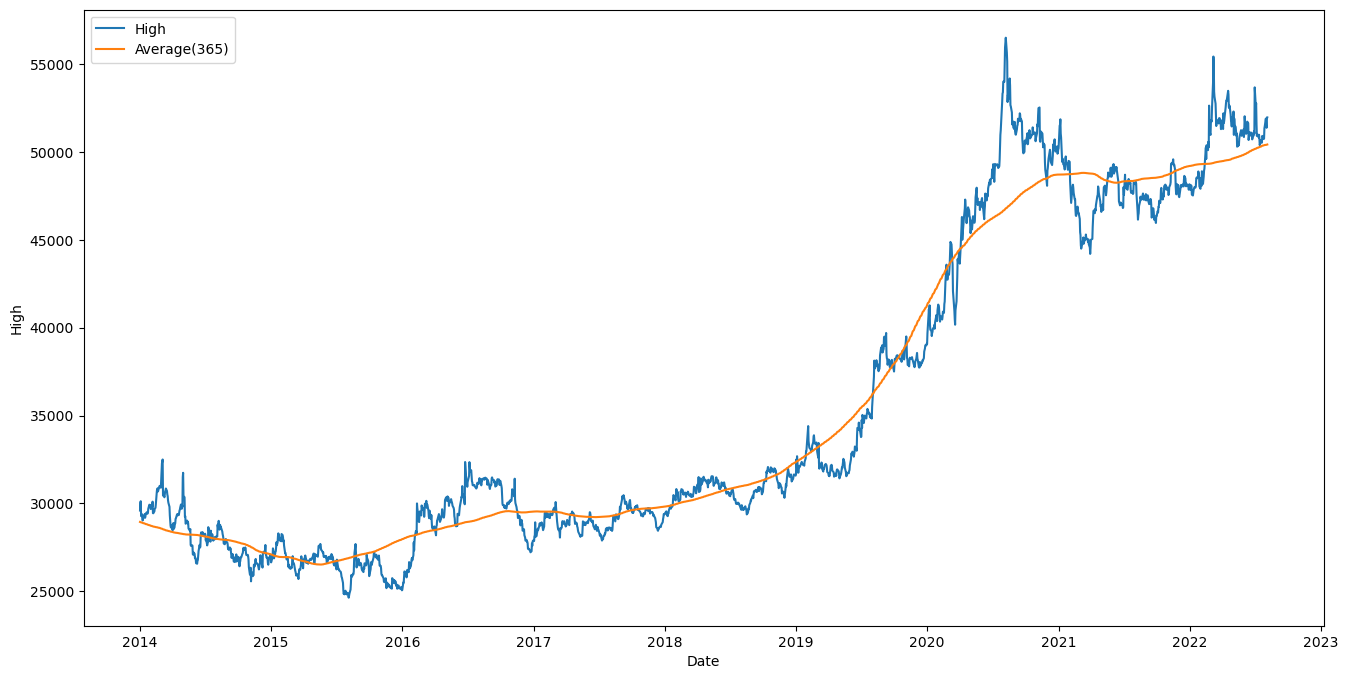

In [15]:
trend_plot(df, 'High', window_size = 365)

In [17]:
def seasonal_plot(dataset: pd.DataFrame, target: str) -> None:
    dataset = dataset.copy()
    dataset['dayofweek'] = dataset.index.dayofweek
    dataset['week'] = pd.Int64Index(dataset.index.isocalendar().week)
    dataset['year'] = dataset.index.year
    figure, axes = plt.subplots(1, 1, figsize = (16, 8))
    axes.set_xticks([0, 1, 2, 3, 4, 5, 6])
    axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    dataset = dataset.groupby(['year', 'week'])

def line(dataset):
    sns.lineplot(data = dataset, x = 'dayofweek', y = target, ax = axes)
  
    dataset.apply(line)
    plt.show()

In [21]:
def periodogram_plot(dataset: pd.DataFrame, target: str, detrend: str= 'linear') -> None:


  # fast fourier transform
    sampling_freq = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
      dataset[target],
      fs = sampling_freq,
      detrend = detrend,
      scaling = 'spectrum',
  )

  # create periodogram
    figure, axes = plt.subplots(1, 1, figsize = (16, 8))
    axes.step(freqencies, spectrum)
    axes.set_xscale("log")
    axes.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    axes.set_xticklabels(
      ["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)",
       "Monthly (12)", "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"],
      rotation=30,
  )
    plt.show()

C:\Users\C J HARINI\AppData\Local\Temp\ipykernel_22028\303211138.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  periodogram_plot(df, 'High')


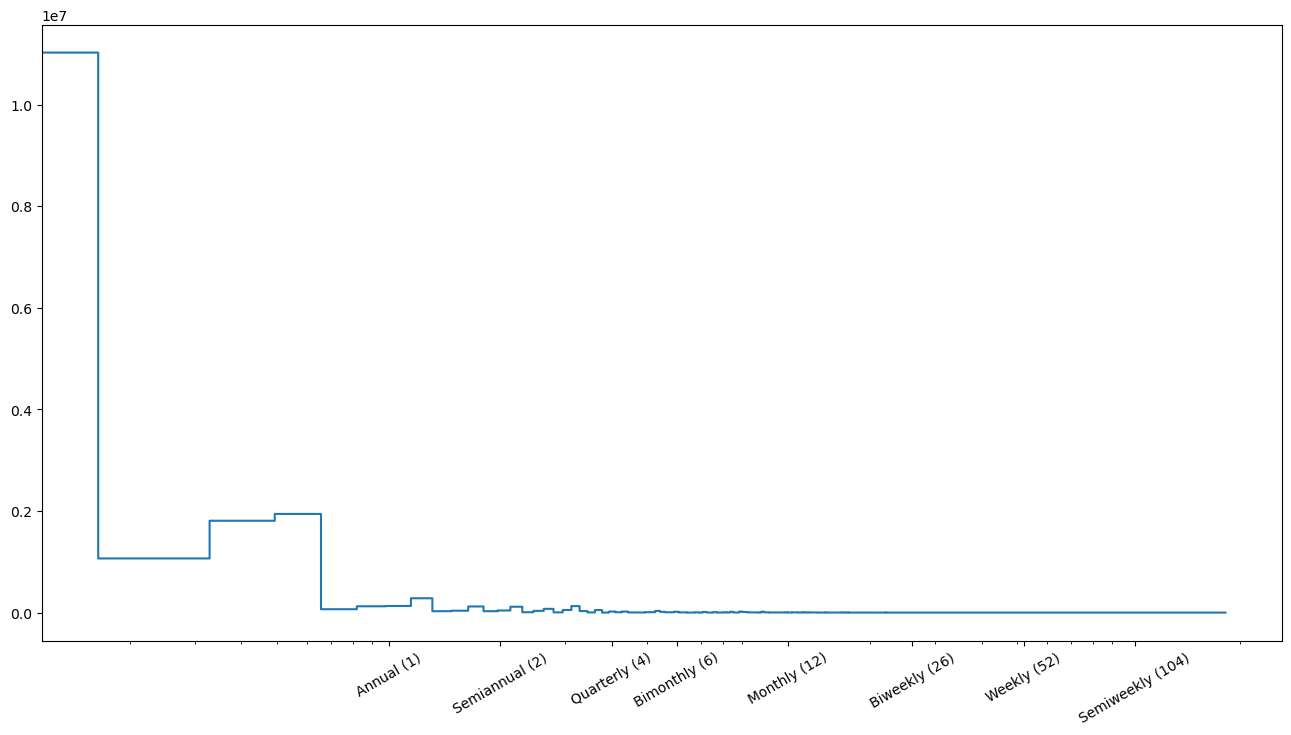

In [22]:
periodogram_plot(df, 'High')

C:\Users\C J HARINI\AppData\Local\Temp\ipykernel_22028\2854187390.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  periodogram_plot(train_df, 'High')


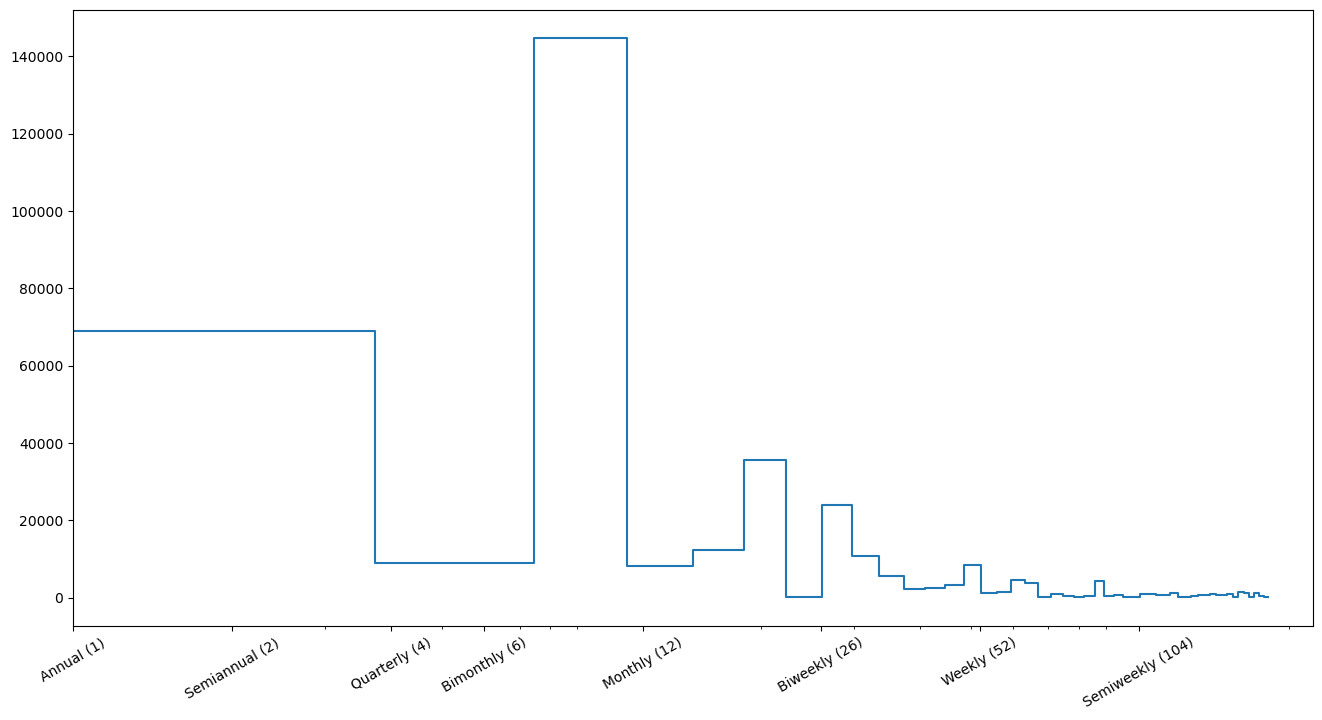

In [23]:
periodogram_plot(train_df, 'High')

In [26]:
def lag_plot(dataset: pd.DataFrame, lags: int, x: str,  y: str = None, nrows: int = 1) -> None:

  # setting default values
    if y is None:
        y = x

  # create lag plot
    ncols = int(np.ceil(lags / nrows))
    figure, axes = plt.subplots(nrows, ncols, figsize = (ncols * 8, nrows * 6), sharex = True, sharey = True, squeeze = False)
    for k in range(lags):
        temp = pd.DataFrame(dataset.loc[:, x])
        lag = pd.DataFrame(temp[x].shift(k + 1)).rename(columns = {x: f'lag {k + 1}'})
        temp = pd.concat([temp, lag], axis = 1).dropna()
        sns.regplot(data = temp, x = x, y = f'lag {k + 1}', ax = axes[k // ncols, k % ncols])
        plt.show()

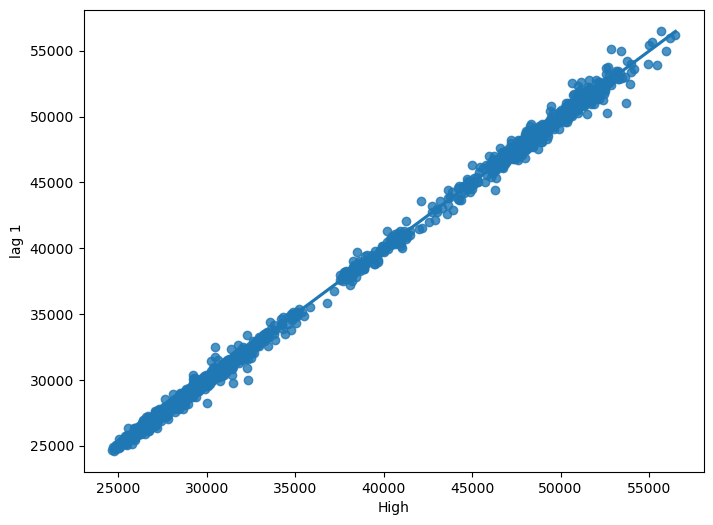

In [31]:
lag_plot(df, lags = 1, x = 'High', nrows = 1)

C:\Users\C J HARINI\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


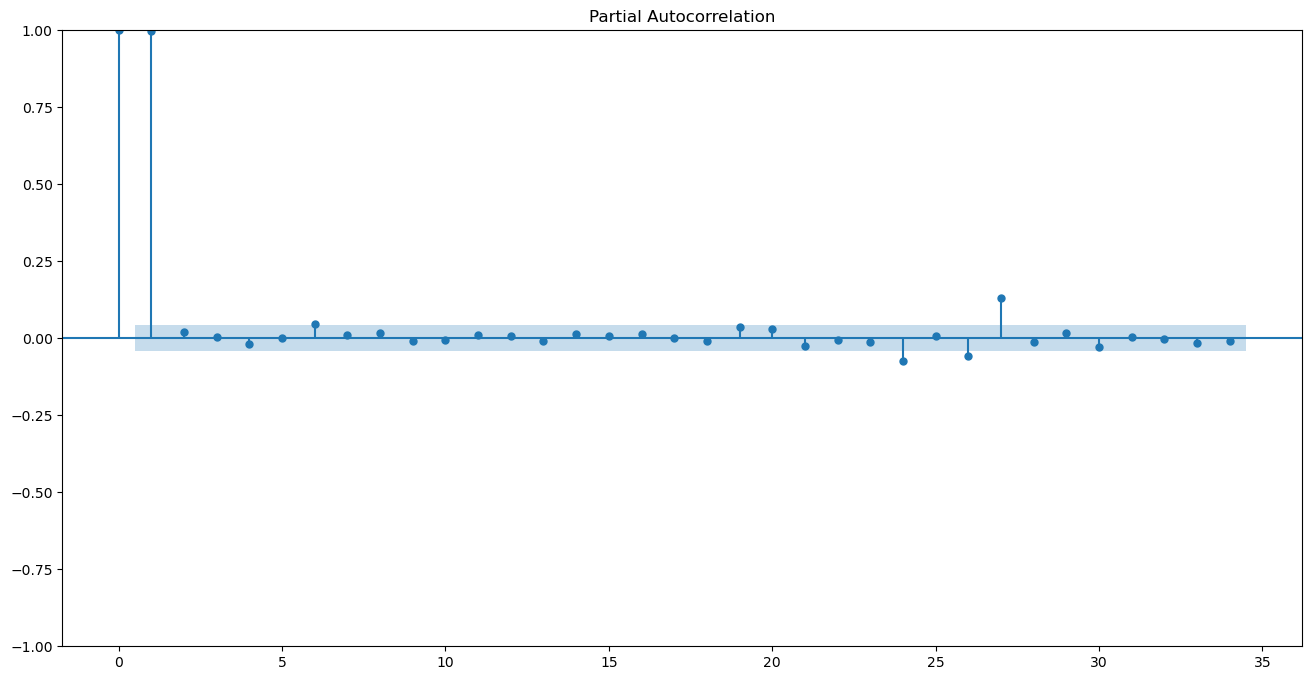

In [28]:
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
_ = plot_pacf(df['High'], ax = ax)
plt.show()

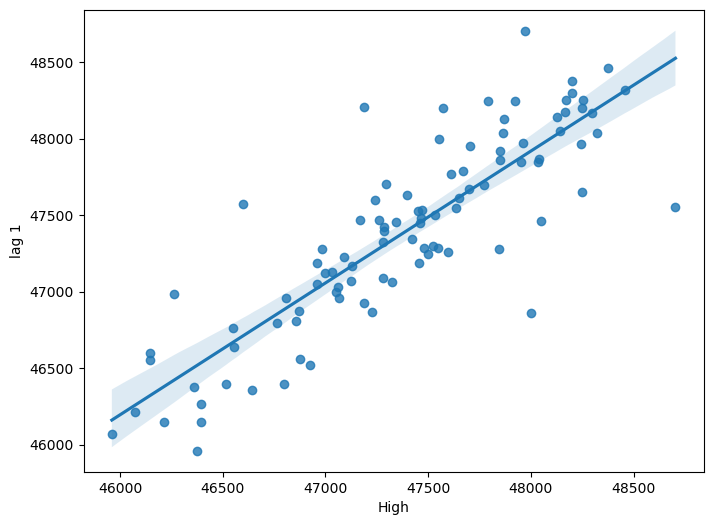

In [32]:
lag_plot(train_df, lags = 1, x = 'High', nrows = 1)

C:\Users\C J HARINI\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


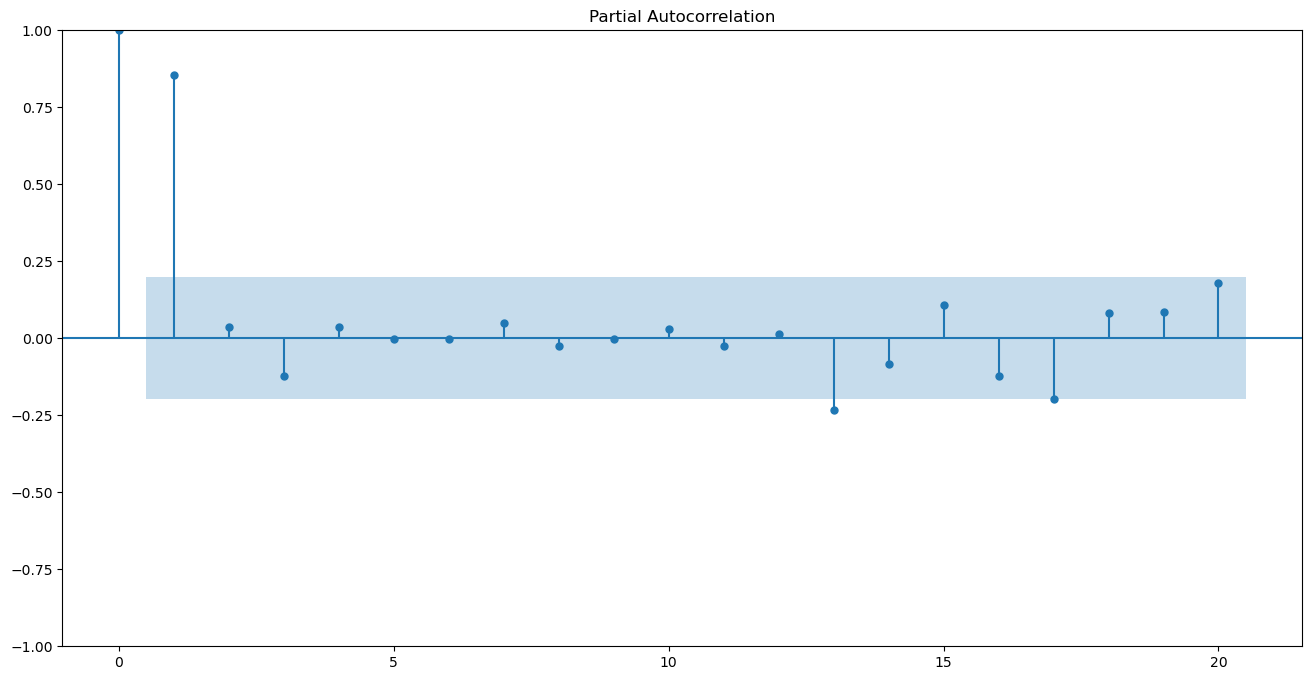

In [35]:
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
_ = plot_pacf(train_df['High'], ax = ax)
plt.show()

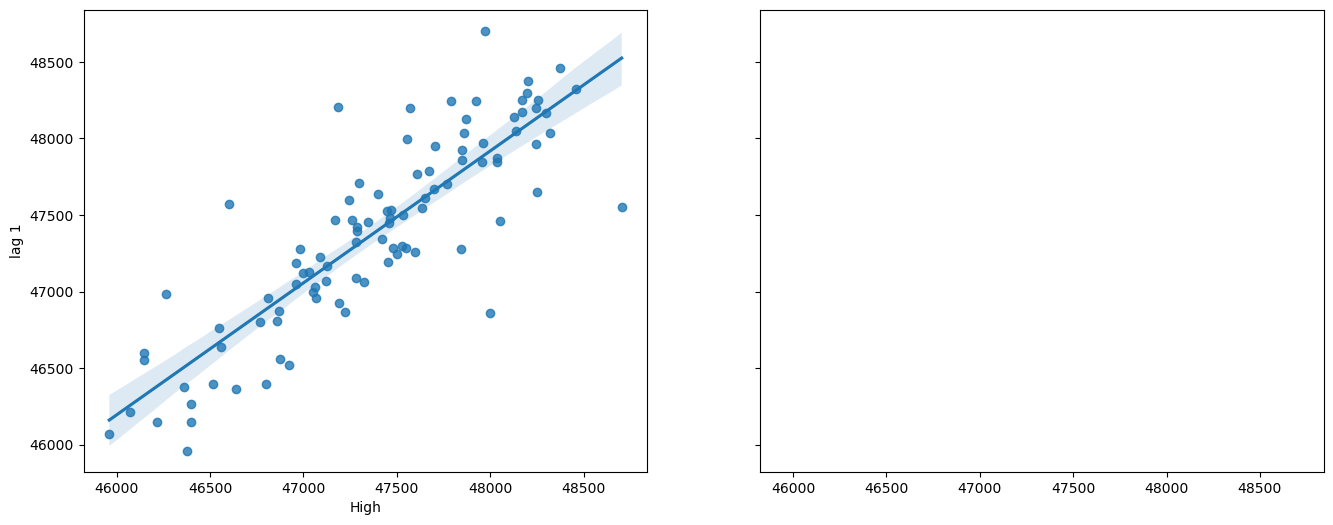

In [39]:
lag_plot(train_df, lags = 2, x = 'High', y = 'Price')

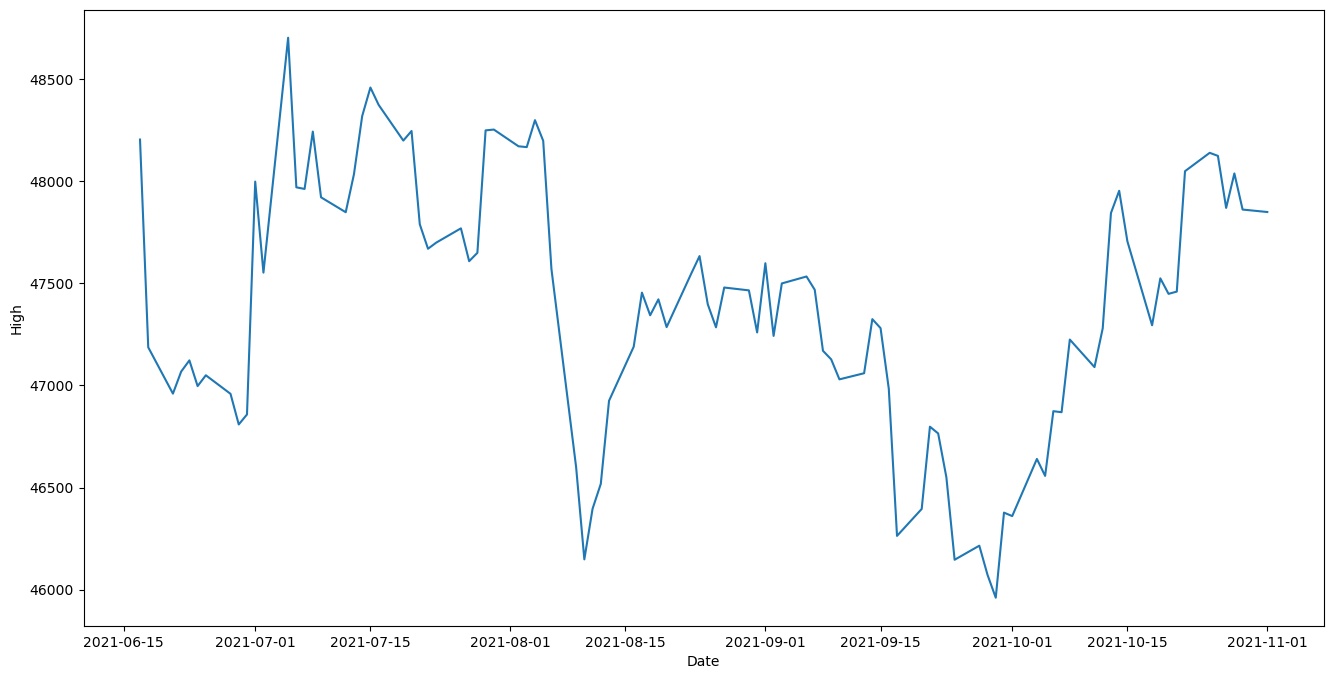

In [38]:
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.lineplot(data = train_df, x = 'Date', y = 'High', ax = ax)
plt.show()


In [40]:
train_start = pd.Timestamp(year = 2021, month = 6, day = 16)
train_end = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_start = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_end = pd.Timestamp(year = 2021, month = 12, day = 9)
test_start = pd.Timestamp(year = 2021, month = 12, day = 9)
test_end = pd.Timestamp(year = 2021, month = 12, day = 29)

train_df = date_split(df, train_start, train_end)
validate_df = date_split(df, validate_start, validate_end)
test_df = date_split(df, test_start, test_end)

print(f"""\
Size of train data:\t {train_df.shape[0]}
Size of validate data:\t {validate_df.shape[0]}
Size of test data:\t {test_df.shape[0]}
""")

Size of train data:	 99
Size of validate data:	 29
Size of test data:	 15



In [42]:
def make_X1(dataset:pd.DataFrame) -> pd.DataFrame:
    fourier = CalendarFourier(freq = "A", order = 1)

    dp = DeterministicProcess(
    index = dataset.index, 
    order = 1,  
    additional_terms = [fourier], 
    drop = True
  )

    X_1 = dp.in_sample()

    return X_1

In [51]:
def make_X2(dataset: pd.DataFrame) -> pd.DataFrame:
    X_2 = pd.DataFrame(index = dataset.index)
    X_2['Price_lag1'] = dataset['Price'].shift(1)
    X_2['High_lag1'] = dataset['High'].shift(1)
    X_2['Low_lag1'] = dataset['Low'].shift(1)
    X_2['Volume_lag1'] = dataset['Volume'].shift(1)
    X_2['Chg%_lag1'] = dataset['Chg%'].shift(1)
    X_2['Open'] = dataset['Open']
    X_2 = X_2.dropna()
  
    return X_2

def make_X(dataset: pd.DataFrame) -> pd.DataFrame:
    X_1 = make_X1(dataset)
    X_2 = make_X2(dataset)
    X_1 = pd.DataFrame(X_1.loc[X_2.index, :])
    return X_1, X_2

def make_Y(dataset: pd.DataFrame, indices) -> pd.DataFrame:
    y = pd.DataFrame(dataset.loc[:, 'High'])
    y = y.loc[indices]
    return y

In [55]:
train_x1, train_x2 = make_X(train_df)
train_y = make_Y(train_df, train_x2.index)
validate_x1, validate_x2 = make_X(validate_df)
validate_y = make_Y(validate_df, validate_x2.index)
test_x1, test_x2 = make_X(test_df)
test_y = make_Y(test_df, test_x2.index)

class HybridModel:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_pred = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = y.columns) 
        y_diff = y - y_pred
        y_diff = y_diff.stack().squeeze() 
        self.model_2.fit(X_2, y_diff)
        self.y_columns = y.columns

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = self.y_columns).stack().squeeze()
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack()

Train RMSE: 91.29681822377962


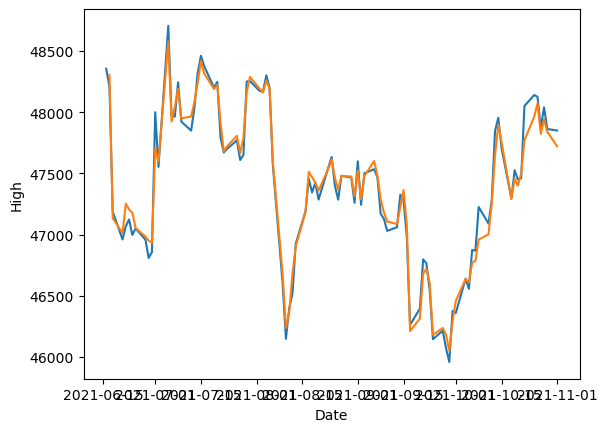

In [56]:
# create model
model = HybridModel(ElasticNet(), RandomForestRegressor())
model.fit(train_x1, train_x2, train_y)

# model predictions
predictions = pd.DataFrame(model.predict(train_x1, train_x2), index = train_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(train_y['High'], predictions['High Prediction']) ** 0.5
print(f"Train RMSE: {RMSE}")
sns.lineplot(data = train_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()


Validate RMSE: 629.1206658229463


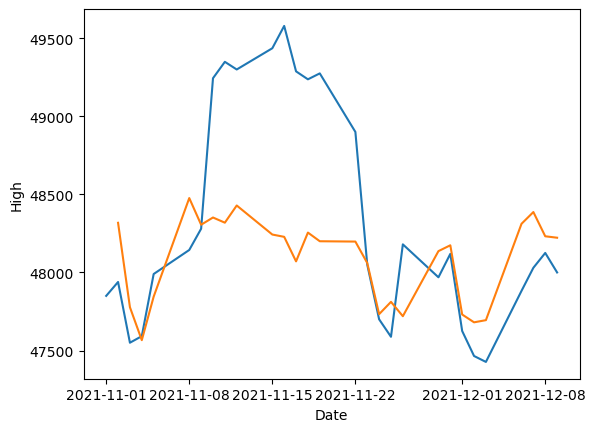

In [57]:
# model predictions
predictions = pd.DataFrame(model.predict(validate_x1, validate_x2), index = validate_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(validate_y['High'], predictions['High Prediction']) ** 0.5
print(f"Validate RMSE: {RMSE}")
sns.lineplot(data = validate_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()

Test RMSE: 245.66075127499204


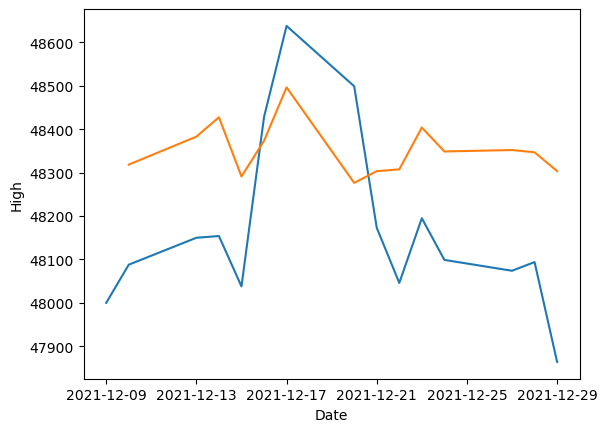

In [58]:
# model predictions
predictions = pd.DataFrame(model.predict(test_x1, test_x2), index = test_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(test_y['High'], predictions['High Prediction']) ** 0.5
print(f"Test RMSE: {RMSE}")
sns.lineplot(data = test_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()

In [59]:
# naive method
residuals = test_df['High'] - test_df['High'].shift(1)
std = residuals.dropna().std()

# confidence testing
if std * 1.96 >= mean_absolute_error(test_y['High'], predictions['High Prediction']):
  print("Model prediction is within 95% confidence")
else:
  print("Model prediction is not within 95% confidence")

Model prediction is within 95% confidence
